In [26]:
import time
import sqlite3
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report  #conf matrix
from sklearn.feature_selection import RFE
import seaborn as sns #conf matrix
from sklearn.feature_selection import chi2
from time import time
import datetime
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
import pickle

# 1. DATA ANALYSIS

The first step is to extract, transform and structure the data and search for possible null or not defined values. Moreover, we will have to convert text/categorical data into numerical data as most of the algorithms work better with numerical inputs and also convert the date values in a way that is readable for python.

In [27]:
cn = sqlite3.connect('../laliga.sqlite')
df = pd.read_sql_query("SELECT * FROM Matches", cn)
df_aux = df
df_aux

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2
...,...,...,...,...,...,...,...,...
49015,2021-2022,2,42,5/29/22,None,Real Oviedo,UD Ibiza,None
49016,2021-2022,2,42,5/29/22,None,Real Sociedad B,Real Zaragoza,None
49017,2021-2022,2,42,5/29/22,None,Sporting Gijón,UD Las Palmas,None
49018,2021-2022,2,42,5/29/22,None,CD Tenerife,FC Cartagena,None


In [3]:
def fix_date(date): 
    if date.year > 2021:
        year = date.year - 100
    else:
        year = date.year
    return datetime.date(int(year),date.month,date.day)
#change date format
df_aux['date'] = pd.to_datetime(df_aux['date']).dt.date
#fix date
df_aux['date'] = df_aux['date'].apply(fix_date)
print(df_aux)

          season  division  matchday        date  time        home_team  \
0      1928-1929         1         1  1929-02-10  None      Arenas Club   
1      1928-1929         1         1  1929-02-10  None         Espanyol   
2      1928-1929         1         1  1929-02-10  None      Real Madrid   
3      1928-1929         1         1  1929-02-10  None         Donostia   
4      1928-1929         1         1  1929-02-12  None           Racing   
...          ...       ...       ...         ...   ...              ...   
49015  2021-2022         2        42  1922-05-29  None      Real Oviedo   
49016  2021-2022         2        42  1922-05-29  None  Real Sociedad B   
49017  2021-2022         2        42  1922-05-29  None   Sporting Gijón   
49018  2021-2022         2        42  1922-05-29  None      CD Tenerife   
49019  2021-2022         2        42  1922-05-29  None  Real Valladolid   

             away_team score  
0      Athletic Madrid   2:3  
1           Real Unión   3:2  
2     

In [4]:
# Search for the winner team
def parse_score(score):
    w = ''
    if score:
        score = score.split(':')
        if score[0] > score[1]:
            w = 1
        elif score[0] < score[1]:
            w = 2
        elif score[0] == score[1]:
            w = 0
    else:
        w = 'Unknown'
    return w

# Match results
scores = df_aux['score'].values
scores = [x.split(':') if x else [-1, -1] for x in scores]
df_aux['Result'] = df_aux['score'].apply(parse_score)

In [5]:
#Home goals and away goals
home_goals = []
away_goals = []
for scored_goals in scores:
    home_goals.append(scored_goals[0])
    away_goals.append(scored_goals[1])
df_aux['home_goals'] = pd.to_numeric(home_goals)
df_aux['away_goals'] = pd.to_numeric(away_goals)

In [6]:
# Goal difference
df_aux['goal_difference'] = abs(df_aux['home_goals'] - df_aux['away_goals'])
df_aux['total_goals'] = df_aux['home_goals'] + df_aux['away_goals']

In [7]:
#Assigning values to each team in order of aparison (encode the label)
teams = df_aux['home_team'].drop_duplicates().values
df_aux['home_id'] = 0
df_aux['away_id'] = 0
df_aux
for i in range(len(teams)):
    df_aux.loc[df_aux['home_team'] == teams[i], ['home_id']] = i
    df_aux.loc[df_aux['away_team'] == teams[i], ['away_id']] = i

#droping unknown
df_aux = df_aux.mask(df_aux.eq('Unknown')).dropna(subset=['Result'])
df_aux = df_aux.mask(df_aux.eq('Unknown')).dropna(subset=['date'])
df_aux.reset_index(drop=True, inplace=True) #reset index after droping the unknown

### SEARCH FOR FEATURES

To be able to predict what will happen in a match it is necessary to look for variables (features) that will be available before the match takes place. This features can be obtained with some means of variables of the last matches. By this way when a team plays on December 3 2020, for example, the code will provide a mean of all the variables available of some of the matches before that one.

In order to achieve this we have focused on the last direct matches between the two teams facing each other. However, as it is possible that the two teams played a long time ago, we have also looked up the last matches played by each team separately.

As we will not have data from previous matches for some teams, we will also have to drop the unknown or missing values.

In [8]:
# new columns for features

#last direct matches
df_aux['FHG_dm'] = np.nan #Feature home goals (last direct matches)
df_aux['FAG_dm'] = np.nan #Feature away goals (last direct matches)
df_aux['FTG_dm'] = np.nan #Feature total goals (last direct matches)
df_aux['FDG_dm'] = np.nan #Feature difference goals (last direct matches)
df_aux['VHT_dm'] = np.nan #victories home team ( last direct matches)
df_aux['VAT_dm'] = np.nan #victories away team ( last direct matches)

#last matches of each team
df_aux['FHG'] = np.nan #Feature home goals (last matches)
df_aux['FAG'] = np.nan #Feature away goals (last matches)
df_aux['VHT'] = np.nan #victories home team ( last matches)
df_aux['VAT'] = np.nan #victories away team ( last matches)

In [9]:
def last_aux(row, num, dict_teams):
    h_t = row['home_id']
    a_t = row['away_id']
    date = row['date']
    
    #get all matches of each team
    matches_h = dict_teams[h_t]
    matches_a = dict_teams[a_t]
    
    #get last matches of each team
    last_matches_h = matches_h[matches_h['date'] < date].sort_values(by = 'date', ascending = False).iloc[0:num,:]
    last_matches_a = matches_a[matches_a['date'] < date].sort_values(by = 'date', ascending = False).iloc[0:num,:]
    
    if ((len(last_matches_h) == num) and (len(last_matches_a) == num)):
        
        #column of away goals, home goals, home victories, away victories
        team_home_hg = last_matches_h['home_goals'][last_matches_h['home_id'] == h_t].sum() 
        team_home_ag = last_matches_h['away_goals'][last_matches_h['away_id'] == h_t].sum()
        team_away_hg = last_matches_a['home_goals'][last_matches_a['home_id'] == a_t].sum()
        team_away_ag = last_matches_a['away_goals'][last_matches_a['away_id'] == a_t].sum()
        
        team_home_vh= (last_matches_h['Result'] == 1)[last_matches_h['home_id'] == h_t].sum(axis=0)
        team_home_va= (last_matches_h['Result'] == 2)[last_matches_h['away_id'] == h_t].sum(axis=0)
        team_away_vh= (last_matches_a['Result'] == 2)[last_matches_a['away_id'] == a_t].sum(axis=0)
        team_away_va= (last_matches_a['Result'] == 1)[last_matches_a['home_id'] == a_t].sum(axis=0)
        
        row['FHG'] = int(team_home_hg + team_home_ag)
        row['FAG'] = int(team_away_hg + team_away_ag)
        row['VHT'] = int(team_home_vh + team_home_va)
        row['VAT'] = int(team_away_vh + team_away_va)
    return row


# This function gets some features for the last num matches for each team
def last_matches_opt(df, num):
    dict_teams = {}
    for team in df['home_id'].unique():
        dict_teams[team] = df[(df['home_id'] == team) | (df['away_id'] == team)]

    return df.apply(lambda row: last_aux(row, num, dict_teams), axis=1)

In [10]:
def last_dir_aux(row, num, dict_teams):
    h_t = row['home_id']
    a_t = row['away_id']
    date = row['date']

    matches_h = dict_teams[h_t]
    matches_a = dict_teams[a_t]
    matches_all = pd.concat([matches_h, matches_a])
    
    #get last matches of direct matches
    last_matches = matches_all[matches_all['date'] < date].sort_values(by = 'date', ascending = False).iloc[0:num,:]
    if (len(last_matches) == num):
        # column of away goals, home goals, home victories, away victories
        total_goals = last_matches['total_goals'].sum()
        diff_goals = last_matches['goal_difference'].sum()
        
        team_home_hg = last_matches['home_goals'][last_matches['home_id'] == h_t].sum() 
        team_home_ag = last_matches['away_goals'][last_matches['away_id'] == h_t].sum()
        team_away_hg = last_matches['home_goals'][last_matches['home_id'] == a_t].sum()
        team_away_ag = last_matches['away_goals'][last_matches['away_id'] == a_t].sum()
        
        team_home_vh = (last_matches['Result'] == 1)[last_matches['home_id'] == h_t].sum(axis=0)
        team_home_va = (last_matches['Result'] == 2)[last_matches['away_id'] == h_t].sum(axis=0)
        team_away_vh = (last_matches['Result'] == 2)[last_matches['away_id'] == a_t].sum(axis=0)
        team_away_va = (last_matches['Result'] == 1)[last_matches['home_id'] == a_t].sum(axis=0)
        
        row['FTG_dm'] = int(total_goals)
        row['FDG_dm'] = int(diff_goals)
        row['FHG_dm'] = int(team_home_hg + team_home_ag)
        row['FAG_dm'] = int(team_away_hg + team_away_ag)
        row['VHT_dm'] = int(team_home_vh + team_home_va)
        row['VAT_dm'] = int(team_away_vh + team_away_va)
        
    return row


# This function gets some features for the last num matches for each team
def last_dir_matches_opt(df, num):
    dict_teams = {}
    for team in df['home_id'].unique():
        dict_teams[team] = df[(df['home_id'] == team) | (df['away_id'] == team)]

    return df.apply(lambda row: last_dir_aux(row, num, dict_teams), axis=1)

In [11]:
df_aux = last_matches_opt(df_aux, 5)
df_aux = last_dir_matches_opt(df_aux, 7)

In [12]:
#droping unknown
df_aux = df_aux.mask(df_aux.eq('Unknown')).dropna(subset=['FHG_dm'])
df_aux = df_aux.mask(df_aux.eq('Unknown')).dropna(subset=['FHG'])

#reset index after droping the unknown
df_aux.reset_index(drop=True, inplace=True)

df_aux['FHG_dm'] = df_aux['FHG_dm'].astype('int')
df_aux['FAG_dm'] = df_aux['FAG_dm'].astype('int')
df_aux['FTG_dm'] = df_aux['FTG_dm'].astype('int')
df_aux['FDG_dm'] = df_aux['FDG_dm'].astype('int')
df_aux['VHT_dm'] = df_aux['VHT_dm'].astype('int')
df_aux['VAT_dm'] = df_aux['VAT_dm'].astype('int')
df_aux['FHG'] = df_aux['FHG'].astype('int')
df_aux['FAG'] = df_aux['FAG'].astype('int')
df_aux['VAT'] = df_aux['VAT'].astype('int')
df_aux['VHT'] = df_aux['VHT'].astype('int')

df_aux

,season,division,matchday,date,time,home_team,away_team,score,Result,home_goals,...,FHG_dm,FAG_dm,FTG_dm,FDG_dm,VHT_dm,VAT_dm,FHG,FAG,VHT,VAT
0,1928-1929,1,6,1929-03-24,None,Espanyol,Real Madrid,4:0,1,4,...,7,7,28,18,2,3,10,14,3,5
1,1928-1929,1,6,1929-03-24,None,Real Unión,Athletic,6:3,1,6,...,8,6,22,10,1,2,10,16,1,3
2,1928-1929,1,6,1929-03-24,None,Arenas Club,Donostia,3:0,1,3,...,6,5,22,8,1,1,8,9,1,2
3,1928-1929,1,6,1929-03-24,None,Athletic Madrid,Racing,4:0,1,4,...,7,1,25,17,2,0,10,2,3,0
4,1928-1929,1,6,1929-03-24,None,Barcelona,Catalunya,5:2,1,5,...,4,4,27,11,0,0,6,9,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47561,2021-2022,2,3,2021-08-28,5:00 PM,Sporting Gijón,CD Mirandés,2:1,1,2,...,1,2,7,7,1,1,2,3,2,1
47562,2021-2022,2,3,2021-08-28,7:30 PM,Real Oviedo,CD Tenerife,0:0,0,0,...,8,6,20,2,0,1,7,5,0,1
47563,2021-2022,2,3,2021-08-28,10:00 PM,Ponferradina,Girona,2:1,1,2,...,4,3,12,6,2,1,5,5,2,3
47564,2021-2022,2,3,2021-08-29,7:30 PM,CD Lugo,Real Valladolid,0:2,2,0,...,5,4,15,5,2,1,6,5,2,1


## 2. FEATURE SELECTION

All of the features we have found might not be useful in building a machine learning model to make the necessary prediction, moreover, some of the features might even make the predictions worse. For this reason, in this section we will select a subset of relevant features that we will use in our model. 

We have decided not to use the home_id and away_id as features because label encoding induces a problem: as it uses number sequencing it can cause a comparison between them, that means that the algorithm can misunderstand the data and think that that it has some kind of order and give more weight to the teams with higher numbers. An alternative to this is doing One-Hot Encoding but due to the amount of teams we have thought that this would not be efficient.

In order to do the feature selection we will use different methods:

In [13]:
y = df_aux['Result'].astype('int')
features = ['FHG_dm','FAG_dm','FTG_dm','FDG_dm','VHT_dm','VAT_dm','FHG','FAG','VHT','VAT']
X = df_aux[features].astype('int')
num_features = 4

### Pearson correlation

We calculate the absolute value of the Pearson's correlation between the target and features which is a number between -1 and 1 that indicates the extent to which two variables are linearly related. This method is a filter-based method.

* A value closer to 0 implies weaker correlation (exact 0 implies no correlation)
* A value closer to 1 implies stronger positive correlation
* A value closer to -1 implies stronger negative correlation

We will keep the top n features based on this criterion.

In [14]:
def Pearson_select(X, y,num_features):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation for each feature
    for i in feature_name:
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # feature name
    feature_selection = X.iloc[:,np.argsort(np.abs(cor_list))[-num_features:]].columns.tolist()
    # feature selection
    cor_support = [True if i in feature_selection else False for i in feature_name]
    return cor_list, feature_selection

cor_list, feature_selection = Pearson_select(X, y,num_features)
print('features selected:', feature_selection)
print('correlations of features:', cor_list)

features selected: ['FDG_dm', 'FTG_dm', 'FAG_dm', 'FAG']
correlations of features: [0.004443568030639411, 0.0499019628252969, 0.044693887383203644, 0.03540358099449101, -0.019718081506831544, 0.02970965477771664, 0.006183374557596299, 0.05600736381038405, -0.017376175120757523, 0.03465332647322684]


### Chi-Square

This is another filter-based method. In this method, we calculate the chi-square metric between the target and the numerical variable and we select the variables with the maximum chi-squared values.

In [15]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_features)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)

4 selected features
['VHT_dm', 'FHG', 'VHT', 'VAT']


### Recursive Feature Elimination

This is a wrapper based method which consist on selecting features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features. Then, the least important ones are eliminated from the current set. That procedure is recursively repeated until the desired number of features is reached. In this case we have used Logistic Regression as the estimator because it is the model we will use.

In [16]:
rfe_selector = RFE(estimator=LogisticRegression(multi_class='ovr', max_iter=500,class_weight="balanced"), n_features_to_select=num_features, step=30, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print('selected features:',str(len(rfe_feature)))
print(rfe_feature)

Fitting estimator with 10 features.
selected features: 4
['FAG_dm', 'FDG_dm', 'FHG', 'FAG']


# 3. SPLIT DATA

In order to run the model we have splited the data randomly using the library ”train test split” from scikit-learn. For the test, it was used 20% of the data. 

In [17]:
features = ['FHG_dm', 'FAG_dm', 'FHG', 'FAG']
target = 'Result'
X = df_aux[features]
y = df_aux[target]
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train = X_train.astype('int')
X_test = X_test.astype('int')
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#size
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (38052, 4)
X_test shape: (9514, 4)
y_train shape: (38052,)
y_test shape: (9514,)


# 4. MODEL AND METRICS

When we have started training the model we have faced with a problem: the data was unbalanced. When that happens, the algorithm learns that a particular class is more common, making it “natural” to have a tendency towards it because just by predicting the majority class, models would score high on accuracy. However, when this happens you do not have a good model, you have a model that assigns the same class to all the observations and does not generalize well.

In order to fix this, we have decided to use a penalized model. Usually, algorithms treat all misclassifications in the same way, so the idea is to penalize misclassifications from the minority class more than the majority. These penalties help the model improve the attention given to the minority class.

To evaluate the model we need to choose a metric. When the data is unbalanced it isn't a good idea to use accuracy as a metric. For this reason we will also use precision, recall and F1-Score (a combination of both recall and precision). 
* Precision: How accurate the positive predictions are
* Recall: Coverage of actual positive sample
    


In [18]:
#General function that trains a model and makes the predictions
def train_test(model, X_train, y_train, X_test, y_test):
    from sklearn import metrics
    #TRAIN
    start = time()
    model.fit(X_train, y_train)
    end = time()
    t = end - start
    print("The model has been trained in {:2f} seconds".format(t))
    
    #PREDICTIONS
    start = time()
    y_pred = model.predict(X_test)
    end = time()
    t = end - start
    print("The predictions have been made in {:2f} seconds".format(t))
    
    #METRICS
    labels = ['Tie', 'Home win', 'Away Win']
    print(metrics.classification_report(y_test, y_pred, target_names=labels))
    print("F1 Score: ", metrics.f1_score(y_test, y_pred, average='macro'))
    print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
    print("Recall: ", metrics.recall_score(y_test, y_pred, average='macro'))
    print("Precision: ", metrics.precision_score(y_test, y_pred, average='macro'))
    
    return y_pred
    

### Logistic Regression

The chosen model has been logistic regression which uses an equation as the representation, very much like linear regression, where the inputs are combined linearly using weights or coefficient values to predict an output value. Logistic regressions are binary classifiers, that means that they can't handle outputs with more than two classes. In our problem, as we have 3 classes, we have used an extension, one-vs-rest logistic regression (OVR), which assumes that each classification problem is independent.  In one-vs-rest logistic regression a separate model is trained for each class predicted whether an observation is that class or not (thus making it a binary classification problem).

In [19]:
lr = LogisticRegression(multi_class='ovr', max_iter=300,class_weight="balanced")

In [20]:
print("Logistic Regression:")
y_pred_lr = train_test(lr, X_train, y_train, X_test, y_test)

Logistic Regression:
The model has been trained in 0.172222 seconds
The predictions have been made in 0.054860 seconds
              precision    recall  f1-score   support

         Tie       0.28      0.31      0.29      2417
    Home win       0.58      0.45      0.50      5006
    Away Win       0.27      0.39      0.32      2091

    accuracy                           0.40      9514
   macro avg       0.38      0.38      0.37      9514
weighted avg       0.44      0.40      0.41      9514

F1 Score:  0.37176426249692324
Accuracy:  0.39846541938196345
Recall:  0.38030781792265994
Precision:  0.3764806476319768


# 5. ANALYSIS OF THE RESULTS

### Confusion_matrix

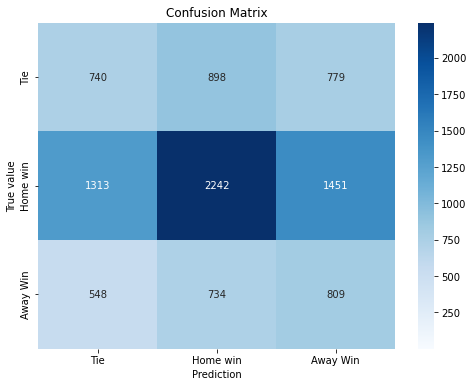

In [21]:
#Print Confusion Matrix
## PONER EN Y_pred el modelo que quieres!!
cm = confusion_matrix(y_test, y_pred_lr)
labels = ['Tie', 'Home win', 'Away Win']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2)
plt.title('Confusion Matrix')
plt.ylabel('True value')
plt.xlabel('Prediction')
plt.show()

### True result, good prediction, bad prediction

In [22]:
index = X_test.index
df_pred = df_aux.loc[index]
df_pred['prediction'] = y_pred_lr
columns = ['season','division','matchday','date','home_team','away_team','Result','prediction']
df_pred = df_pred[columns]

In [23]:
result = df_pred['Result'].value_counts()
pred = df_pred[['prediction','Result']]
good_pred = pred[pred['prediction'] == pred['Result']].value_counts()
good_pred.reset_index(drop=True, inplace=True, level='Result')

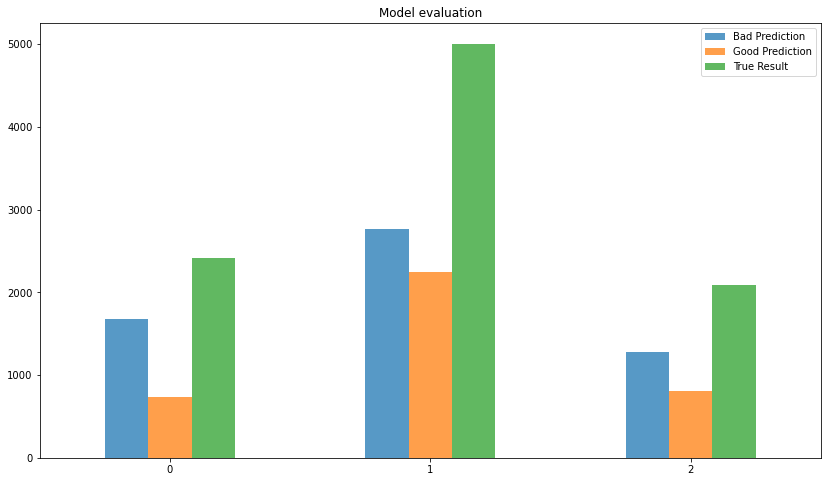

In [24]:
bad_pred = pred[(pred['prediction'] != pred['Result'])].groupby('Result').count()
bad_pred = bad_pred['prediction']
evaluation = pd.concat([bad_pred, good_pred,result], axis=1, 
                        keys=['Bad Prediction','Good Prediction','True Result']
                      ).plot(kind='bar',figsize=(14,8),title="Model evaluation",alpha=0.75, rot=0)

### Analysis of failures and successes

Result        0     1    2
prediction                
0           740  1313  548
1           898  2242  734
2           779  1451  809


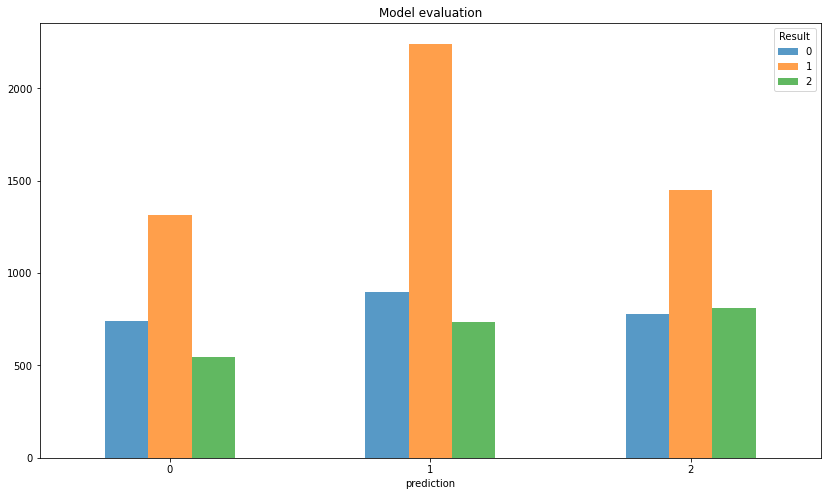

In [25]:
fail_suc = pred[(pred['prediction'] != pred['Result']) | (pred['prediction'] == pred['Result']) ].value_counts()
fail_suc = pd.DataFrame(fail_suc)
fail_suc = fail_suc.unstack()
fail_suc[0].plot(kind='bar',
            figsize=(14,8),
            title="Model evaluation",alpha=0.75, rot=0)

print(fail_suc[0])

# 6. EXPORT MODEL

This only exports the last model run and the TEST

In [ ]:
#Replace 0 with X
df_pred[['Result','prediction']] = df_pred[['Result','prediction']].astype(str) 
df_pred[['Result','prediction']] = df_pred[['Result','prediction']].replace('0','X')

In [ ]:
shouldExport = input('Do you want to export the model(s) (y / n) ? ')
if shouldExport.strip().lower() == 'y':
    df_pred.to_excel("../models/Predictions.xlsx")
    pickle.dump(lr, open('../models/modelQuiniela.p', "wb"))